<a href="https://colab.research.google.com/github/Nimere1990/DDPG-/blob/main/%D0%95%D1%80%D1%91%D0%BC%D0%B8%D0%BD_%D0%98_%D0%95_%2245_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pendulum-v1**

**Задание:**
1. Реализовать базовый DDPG
2. Обучить агента удерживать маятник вверх
3. Достичь средней награды -200 или выше

```
Параметры среды:
- Состояния: 3 (cos угла, sin угла, угловая скорость)
- Действия: 1 (непрерывное, крутящий момент)
- Награда: отрицательная, зависит от угла и действия
```


1. Визуализация процесса обучения:
   - График наград по эпизодам
   - График функции потерь

2. Базовый анализ результатов:
   - Среднее значение наград
   - Стабильность обучения
   - Время сходимости

3. Код должен содержать:
  - Реализацию класса
  - Базовую функцию обучения (сбор опыта, обновление сети, логирование результатов)
  - Функцию тестирования (запуск обученного агента, запись видео)

4. Простой отчет:
   - Описание реализованного алгоритма
   - Графики обучения
   - Выводы о работе агента


In [ ]:
!pip install swig gym==0.25.2 gym[box2d] gymnasium  > /dev/null 2>&1
!pip install --upgrade pyvirtualdisplay ipykernel > /dev/null 2>&1

In [ ]:
# Импорты основных библиотек
import gym                                                                      # Импортируем библиотеку Gym для работы с окружениями
import numpy as np                                                              # Импортируем библиотеку NumPy для работы с массивами
import torch                                                                    # Импортируем PyTorch
import torch.nn as nn                                                           # Импортируем модуль для создания нейронных сетей
import torch.optim as optim                                                     # Импортируем оптимизаторы
import random                                                                   # Импортируем модуль для случайной выборки
import matplotlib.pyplot as plt                                                 # Импортируем Matplotlib для построения графиков
from collections import deque                                                   # Импортируем дек для буфера воспроизведения
import copy                                                                     # Импортируем модуль для глубокого копирования объектов
from IPython import display as ipythondisplay                                   # Импортируем для отображения видео в Jupyter
from gym.wrappers import RecordVideo                                            # Импортируем обертку для записи видео
import os                                                                       # Импортируем для работы с файловой системой
import base64                                                                   # Импортируем для кодирования видео

In [ ]:
# Определение архитектуры актера
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()                                           # Инициализация базового класса
        self.max_action = max_action                                            # Храним максимальное действие для масштабирования
        # Определяем нейронную сеть актера
        self.net = nn.Sequential(
            nn.Linear(state_dim, 400),                                          # Входной слой
            nn.ReLU(),                                                          # Функция активации ReLU
            nn.Linear(400, 300),                                                # Скрытый слой
            nn.ReLU(),                                                          # Функция активации ReLU
            nn.Linear(300, action_dim),                                         # Выходной слой
            nn.Tanh()                                                           # Функция активации Tanh для нормализации выхода
        )

    def forward(self, state):
        return self.max_action * self.net(state)                                # Масштабируем выходы актера

# Определение архитектуры критика
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()                                          # Инициализация базового класса
        # Определяем нейронную сеть критика
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 400),                             # Входной слой (состояние + действие)
            nn.ReLU(),                                                          # Функция активации ReLU
            nn.Linear(400, 300),                                                # Скрытый слой
            nn.ReLU(),                                                          # Функция активации ReLU
            nn.Linear(300, 1)                                                   # Выходной слой для Q-значения
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], 1))                          # Объединение состояния и действия

# DDPG агент
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)                   # Создаем актера
        self.actor_target = copy.deepcopy(self.actor)                           # Целевая версия актера
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)     # Оптимизатор актера

        self.critic = Critic(state_dim, action_dim)                             # Создаем критика
        self.critic_target = copy.deepcopy(self.critic)                         # Целевая версия критика
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)   # Оптимизатор критика

        self.memory = deque(maxlen=100000)                                      # Буфер для хранения опыта
        self.batch_size = 64                                                    # Размер батча для обучения
        self.gamma = 0.99                                                       # Коэффициент дисконтирования
        self.tau = 0.001                                                        # Коэффициент мягкого обновления
        self.losses = []                                                        # Список для хранения значений потерь
        self.episode_rewards = []                                               # Список для хранения наград по эпизодам

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))                         # Преобразуем состояние в тензор
        with torch.no_grad():                                                   # Выключаем градиенты для выборки действия
            return self.actor(state).data.numpy().flatten()                     # Получаем действие от актора

    def train(self):
        if len(self.memory) < self.batch_size:                                  # Проверяем, достаточно ли опыта для обучения
            return

        batch = random.sample(self.memory, self.batch_size)                     # Выборка случайного батча из памяти
        state_batch = torch.FloatTensor([s[0] for s in batch])                  # Извлечение состояний
        action_batch = torch.FloatTensor([s[1] for s in batch])                 # Извлечение действий
        reward_batch = torch.FloatTensor([s[2] for s in batch]).unsqueeze(1)    # Извлечение вознаграждений
        next_state_batch = torch.FloatTensor([s[3] for s in batch])             # Извлечение следующих состояний
        done_batch = torch.FloatTensor([s[4] for s in batch]).unsqueeze(1)      # Извлечение индикаторов завершения эпизода

        with torch.no_grad():                                                   # Выключаем градиенты для целевого Q-значения
            next_actions = self.actor_target(next_state_batch)                  # Получаем действия целевого актера
            target_Q = self.critic_target(next_state_batch, next_actions)       # Получаем целевое Q-значение
            target_Q = reward_batch + (1 - done_batch) * self.gamma * target_Q  # Рассчитываем целевое Q-значение

        current_Q = self.critic(state_batch, action_batch)                      # Получаем текущее Q-значение
        critic_loss = nn.MSELoss()(current_Q, target_Q.detach())                # Вычисляем функцию потерь для критика
        self.losses.append(critic_loss.item())                                  # Сохраняем значение потерь

        self.critic_optimizer.zero_grad()                                       # Обнуляем градиенты
        critic_loss.backward()                                                  # Обратное распространение ошибок для критика
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)             # Клиппинг градиентов для стабильности
        self.critic_optimizer.step()                                            # Обновляем веса критика

        actor_loss = -self.critic(state_batch, self.actor(state_batch)).mean()  # Рассчитываем потери актера

        self.actor_optimizer.zero_grad()                                        # Обнуляем градиенты
        actor_loss.backward()                                                   # Обратное распространение ошибок для актера
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)              # Клиппинг градиентов
        self.actor_optimizer.step()                                             # Обновляем веса актера

        # Мягкое обновление целевых сетей
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)  # Обновляем целевой критик

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)  # Обновляем целевой актер

    def log_results(self, episode_reward):
        self.episode_rewards.append(episode_reward)                             # Сохраняем награду за эпизод
        if len(self.episode_rewards) % 10 == 0:                                 # Каждые 10 эпизодов
            print(f"Эпизод {len(self.episode_rewards)}, Награда: {episode_reward:.2f}")  # Выводим результаты

# Функция для обучения агента
def train_agent(agent, env, num_episodes=1000):
    for episode in range(num_episodes):                                         # Цикл по числу эпизодов
        state = env.reset()                                                     # Сбрасываем окружение
        episode_reward = 0                                                      # Инициализация награды за эпизод

        for t in range(1000):                                                   # Максимум 1000 шагов в эпизоде
            action = agent.select_action(state)                                 # Получаем действие от агента
            next_state, reward, done, truncated = env.step(action)              # Выполняем действие в окружении

            agent.memory.append((state, action, reward, next_state, float(done)))  # Сохраняем опыт в памяти
            agent.train()                                                       # Обучаем агента с использованием собранного опыта

            state = next_state                                                  # Обновляем текущее состояние
            episode_reward += reward                                            # Добавляем награду за шаг

            if done or truncated:                                               # Проверяем, закончился ли эпизод
                break

        agent.log_results(episode_reward)                                       # Логируем награды за эпизод

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [ ]:
env = gym.make('Pendulum-v1', render_mode='rgb_array')                          # Создаем окружение Pendulum
state_dim = env.observation_space.shape[0]                                      # Получаем размерность состояния
action_dim = env.action_space.shape[0]                                          # Получаем размерность действия
max_action = float(env.action_space.high[0])                                    # Получаем максимальное действие

agent = DDPGAgent(state_dim, action_dim, max_action)                            # Создаем экземпляр агента

# Обучаем агента
train_agent(agent, env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Эпизод 10, Награда: -1439.64
Эпизод 20, Награда: -1496.56
Эпизод 30, Награда: -1233.49
Эпизод 40, Награда: -1048.10
Эпизод 50, Награда: -1086.57
Эпизод 60, Награда: -936.89
Эпизод 70, Награда: -918.89
Эпизод 80, Награда: -847.14
Эпизод 90, Награда: -650.46
Эпизод 100, Награда: -400.72
Эпизод 110, Награда: -400.17
Эпизод 120, Награда: -132.77
Эпизод 130, Награда: -346.71
Эпизод 140, Награда: -132.81
Эпизод 150, Награда: -125.94
Эпизод 160, Награда: -121.41
Эпизод 170, Награда: -123.14
Эпизод 180, Награда: -128.77
Эпизод 190, Награда: -231.49
Эпизод 200, Награда: -239.17
Эпизод 210, Награда: -128.01
Эпизод 220, Награда: -260.71
Эпизод 230, Награда: -292.58
Эпизод 240, Награда: -115.24
Эпизод 250, Награда: -117.20
Эпизод 260, Награда: -226.26
Эпизод 270, Награда: -0.53
Эпизод 280, Награда: -364.23
Эпизод 290, Награда: -128.36
Эпизод 300, Награда: -120.27
Эпизод 310, Награда: -223.37
Эпизод 320, Награда: -128.65
Эпизод 330, Награда: -114.46
Эпизод 340, Награда: -129.39
Эпизод 350, Награда:

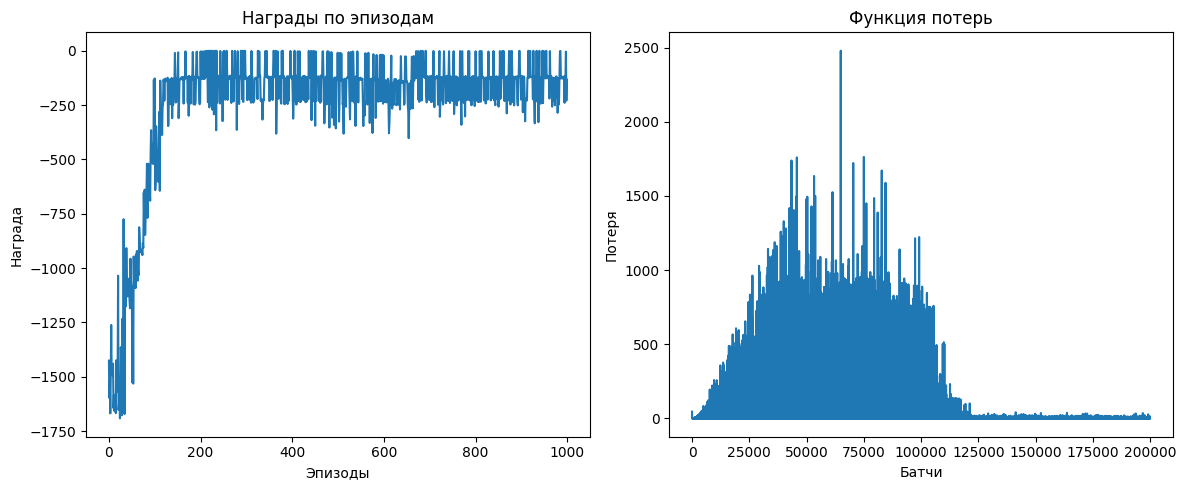

In [ ]:
# Построение графиков наград и потерь
plt.figure(figsize=(12, 5))                                                     # Устанавливаем размер графика

# График наград
plt.subplot(1, 2, 1)                                                            # Создаем подграфик для наград
plt.plot(agent.episode_rewards)                                                 # График наград по эпизодам
plt.title('Награды по эпизодам')                                                # Заголовок графика
plt.xlabel('Эпизоды')                                                           # Подпись по оси X
plt.ylabel('Награда')                                                           # Подпись по оси Y

# График функции потерь
plt.subplot(1, 2, 2)                                                            # Создаем подграфик для потерь
plt.plot(agent.losses)                                                          # График потерь по батчам
plt.title('Функция потерь')                                                     # Заголовок графика
plt.xlabel('Батчи')                                                             # Подпись по оси X
plt.ylabel('Потеря')                                                            # Подпись по оси Y

plt.tight_layout()                                                              # Автоматическая настройка расположения графиков
plt.show()                                                                      # Отображаем графики


In [ ]:
def record_episode(env, agent, video_dir="./video"):
    os.makedirs(video_dir, exist_ok=True)                                       # Создаем директорию для видео, если её нет
    env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda x: x == 0)  # Обертывание для записи видео
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state)
        state, reward, done, truncated = env.step(action)
        total_reward += reward
        if done or truncated:
            break

    env.close()                                                                 # Закрываем окружение

    # Получаем полный путь к записанному видео
    video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
    if video_files:
        latest_file = max(video_files, key=lambda f: os.path.getmtime(os.path.join(video_dir, f)))  # Последний файл
        return os.path.join(video_dir, latest_file)                             # Возвращаем полный путь к файлу
    return None                                                                 # Если видео не записано, возвращаем None

# Функция для отображения видео
def show_video(video_path):
    if video_path and os.path.exists(video_path):                               # Проверяем, существует ли файл видео
        video = open(video_path, "rb").read()                                   # Читаем видео файл
        video_encoded = base64.b64encode(video).decode('utf-8')                 # Кодируем его в base64
        video_tag = '<video controls alt="test" src="data:video/mp4;base64,{0}">'.format(video_encoded)  # Создаем HTML тег для видео
        ipythondisplay.display(ipythondisplay.HTML(data=video_tag))             # Отображаем видео
    else:
        print("Видео не найдено.")                                              # Сообщение об ошибке, если видео не найдено


# Тестируем агента и записываем видео
video_path = record_episode(env, agent)                                         # Записываем эпизод
print("\nЗаписываем видео успешного эпизода...")
show_video(video_path)                                                          # Показываем записанное видео

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Записываем видео успешного эпизода...


**Описание реализованного алгоритма**

Реализованный алгоритм представляет собой DDPG (Deep Deterministic Policy Gradient), который предназначен для обучения агентов, работающих в непрерывных пространствах действий.

***Actor-Critic Architecture:***

***Актер*** (Actor) генерирует действия на основе текущего состояния окружения. Он принимает состояние как вход и выдает действие (действие нормализуется в диапазоне от -макс до +макс).

***Критик*** (Critic) оценивлет значение действия, которое принимает агент, вычисляя Q-значение для пары состояние-действие. Это значение отражает ожидаемое вознаграждение агента, если он выполнит это действие из данного состояния.

Агент использует буфер памяти (deque) для хранения опыта, что позволяет ему повторно использовать ранее собранные данные для обучения. Это улучшает эффективность и стабильность обучения.


***Графики обучения***

Графики, созданные после выполнения обучения, показывают следующее:

График наград по эпизодам:
Отображает, как награды агента меняются по мере обучения. Как мы видим на графике ближе к 200 эпизоду получение наград стабилизируется и находится в районе -200 очков


***График функции потерь:***

Этот график показывает изменения в потере критика, что позволяет отслеживать эффективность обучения. Снижение потерь говорит о том, что Q-значения обучаются более точно.


***Выводы о работе агента***

***Эффективность обучения:***

График наград демонстрирует устойчивый рост, это указывает на то, что агент способен эффективно изучать и улучшать свою стратегию в заданной среде.

Снижение функции потерь также указывает на стабильное обучение агента.


Таким образом, агент, обученный с использованием DDPG, демонстрирует способности к обучению в непрерывных задачах, но результаты могут варьироваться в зависимости от настройки и сложности среды.